# Frame the problem

- What is the business goal? --> Algorithm, how to evaluate, how to tune the model. 
- What is the current situation?
- Supervised, unsupervised or reinforcement learning? Classification or regression? Use batch learning(数据量不大) or online learning techniques(Mapreduce)? 

# Select a performance measure

Eg: RMSE等于50000，意味着68%的系统预测值位于实际值的50000美元以内，95%的预测值位于实际值的100000美元以内(一个特征通常都符合高斯分布，即满足“68-95-99.7”规则: 大约68%的值落在1σ内，95%的值落在2σ内，99.7%的值落在3σ内。

有多种测量距离的方法，或范数:
- 计算对应欧几里得范数(Euclidean norm)的平方和的根(RMSE): 也称作$l_2$范数(l2 norm)，标记为$||•||_2$(或$||•||$)
- 计算对应于$l_1$(标记为$||•||_1$)范数的绝对值和(MAE)，也称为曼哈顿范数(Manhattan norm)，因为它测量了城市中的两点沿着矩形的边行走的距离。
- 更一般的，包含n个元素的向量v的$l_k$ 范数(K阶闵氏范数)，定义成$||v||_k=(|v_0|^k+|v_1|^k+...+|v_n|^k)^(1/k)$。$l_0$(汉明范数)只显示了这个向量非零元素的个数，$l_∞$(切比雪夫范数)是向量中最大的绝对值。
- 范数的指数越高，就越关注大的值而忽略小的值。这就是为什么RMSE比MAE对异常值更敏感。但是当异常值是指数分布的(类似正态曲线)，RMSE就会表现很好。

# Check the assumptions
输出是分类还是回归

# Download the data

写一个脚本随时获取最新的数据

In [17]:
import os #pwd etc
import tarfile #用于解压
from six.moves import urllib #six用于兼容python2&3

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [18]:
fetch_housing_data()

写一个函数用于加载数据

In [19]:
import pandas as pd

def load_housing_data(housing_path=Housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [26]:
california_housing = load_housing_data()

# Take a quick look at the data structure

In [28]:
california_housing.head() #查看数据前5行

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [29]:
california_housing.info() #快速查看数据的描述

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


ocean_proximity为object，因此可以包含任意Python对象，但是因为该项是从CSV文件加载的，所以必然是文本类型。

In [31]:
california_housing["ocean_proximity"].value_counts() #value_counts()方法查看该项中都有哪些类别，每个类别中都包含有多少个街区

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

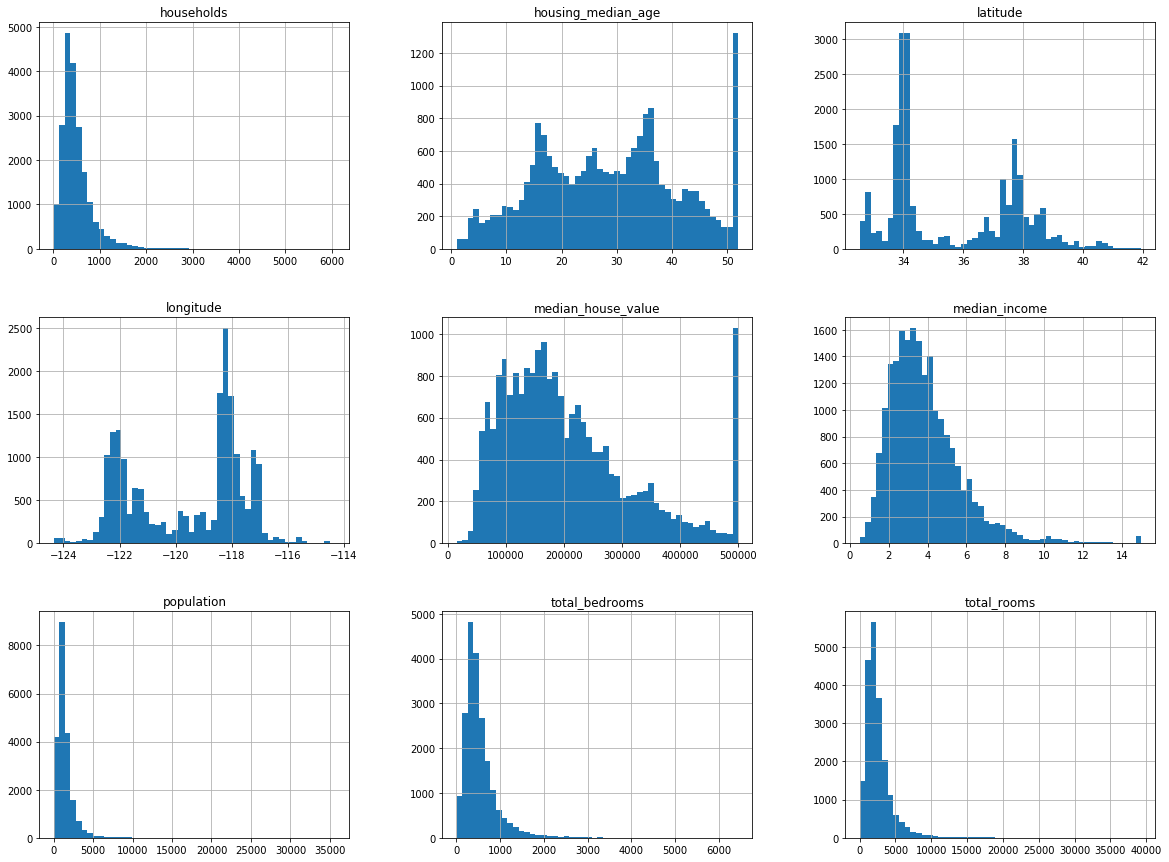

In [38]:
california_housing.describe() #数值属性概括

#另一种快速了解数据类型的方法：画出每个数值属性的柱状图
%matplotlib inline 
#告诉Jupyter设定好Matplotlib，以使用 Jupyter自己的后端将图形后端以打印到屏幕上。
import matplotlib.pyplot as plt
california_housing.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show() #所以调用show()不是必要的，因为代码框执行后Jupyter会自动展示图像。

housing_median_age和median_house_value都被设置了上限, median_house_value是严重问题，因为是target，有两种解决方案:
- Collect proper labels for the districts whose label were capped.
- Remove those districts from the training set and test set. 

# Create a test set

In [41]:
np.random.seed(42)

In [42]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [44]:
train_set, test_set = split_train_test(california_housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


但是如果数据集更新，方法会失效。一个通常的解决办法是使用每个实例的ID来判定这个实例是否应该放入测试集(假设每个实例都有唯一并且不变的ID)。例如，你可以计算出每个实例ID的哈希值，只保留其最后一个字节，如果该值小于等于51(约为256的20%)，就将其放入测试集。这样可以保证在多次运行中，测试集保持不变，即使更新了数据集。新的测试集会包含新实例中的20%，但不会有之前位于训练集的实例。下面是一种可用的方法:

In [ ]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
# 使用行索引作为 ID
housing_with_id = california_housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [ ]:
# 如果使用行索引作为唯一识别码，你需要保证新数据都放到现有数据的尾部，且没有行被删除。如果做不到，则可以用最稳定的特征来创建唯一识别码。
# 例如，一个区的维度和经度在几百万年之内是不变的，所以可以将两者结合成一个ID: 
housing_with_id["id"] = california_housing["longitude"] * 1000 + california_housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

也可以使用scikit-learn分割数据集

In [46]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(california_housing, test_size=0.2, random_state=42)

In [47]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


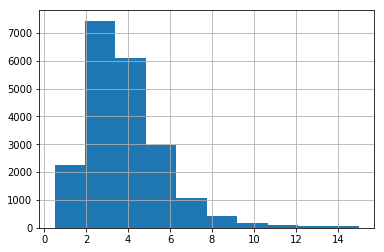

In [49]:
california_housing["median_income"].hist()

In [50]:
# pd.cut可以将原数据切割，并制定每类的label
california_housing["income_cat"] = pd.cut(california_housing["median_income"],
                                         bins=[0.,1.5,3.0,4.5,6., np.inf],
                                         labels=[1,2,3,4,5])

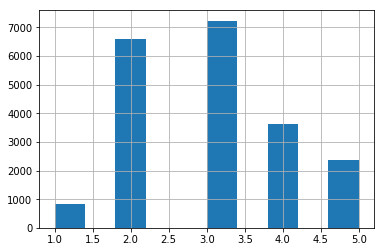

In [51]:
california_housing["income_cat"].hist()

可以根据收入分类，进行分层采样

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(california_housing,california_housing["income_cat"]):
    strat_train_set = california_housing.loc[train_index]
    strat_test_set = california_housing.loc[test_index]

查看收入分配比例

In [53]:
california_housing["income_cat"].value_counts()/len(california_housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

比较随机抽样和分层抽样与总数据集中收入分配比例

In [54]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(california_housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(california_housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [55]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


删除"income_cat"，使数据回到初始状态:

In [57]:
for set in (strat_train_set,strat_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)

# Discover and visualize the data to gain insights

## Visualizing geographical data

In [58]:
# 创建副本以免损伤训练集
housing = strat_train_set.copy()

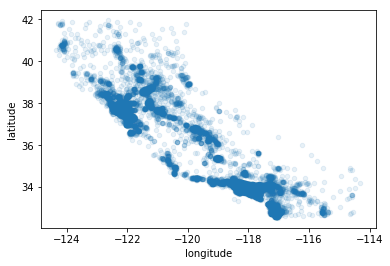

In [66]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1) #alpha为transparency

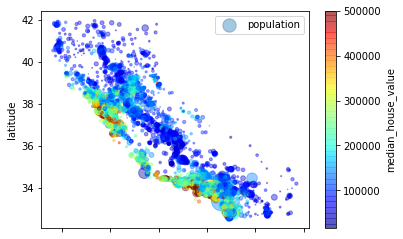

In [69]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value",cmap=plt.get_cmap("jet"), colorbar=True) #s圈的半径代表人口，c颜色代表价格
plt.legend()

在地图上显示：

In [74]:
# Download the California image
PROJECT_ROOT_DIR = "root_directory"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('/Users/yanzihao/Desktop/GitHub/Machine-Learning/images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x1315d2690>)

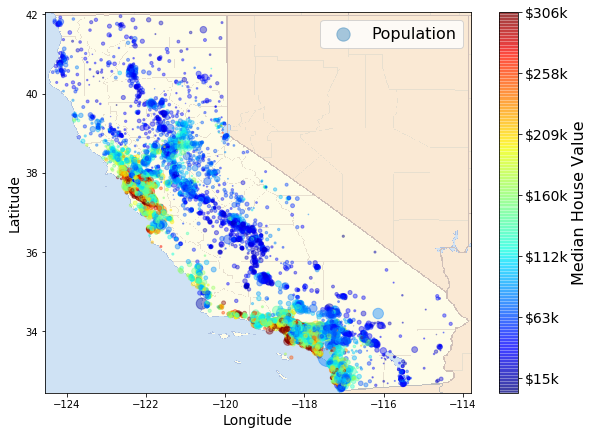

In [76]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
#save_fig("california_housing_prices_plot")
plt.show()

## Find correlations

In [70]:
corr_matrix = housing.corr()

查看每个属性和房价中位数的关联度:

In [71]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131e67d90>,
      dtype=object)

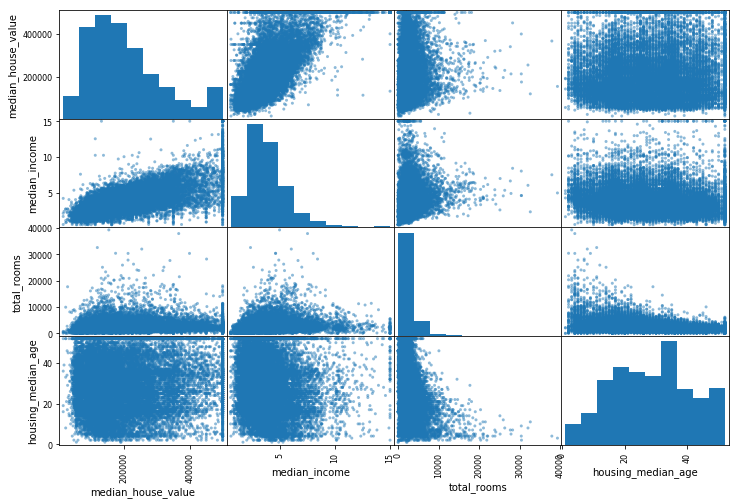

In [78]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
#save_fig("scatter_matrix_plot")

focus on median_house_value and median_income

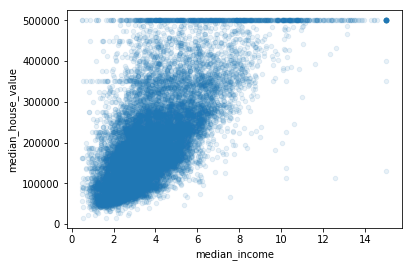

In [79]:
housing.plot(kind="scatter", x="median_income",y="median_house_value", alpha=0.1)

- 相关性非常高，可以清晰地看到向上的趋势，并且数据点不是非常分散。
- 之前看到的最高价，清晰地呈现为一条位于500000美元的水平线。这张图也呈现了一些不是那么明显的直线:一条位于450000美元的直线，一条位于350000 美元的直线，一条在280000美元的线，和一些更靠下的线。可能希望去除对应的街区，以防止算法重复这些巧合。

## Experimenting with attribute combinations(属性组合试验)

create new meaningful features:

In [80]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

In [82]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the data for ML algorithms

In [83]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning

total_bedrooms有missing values，有三种解决方案：
1. 去掉对应街区
2. 去掉整个attribute
3. 赋值

In [ ]:
housing.dropna(subset=["total_bedrooms"]) # 1方案

In [ ]:
housing.drop("total_bedrooms", axis=1) # 2方案

In [ ]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median) # 3方案

也可以用sklearn解决：

In [87]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

#因为只有数值属性才能算出中位数，需要创建一份不包括文本属性ocean_proximity的数据副本:
housing_num = housing.drop("ocean_proximity", axis=1)
#用fit()方法将imputer实例拟合到训练数据:
imputer.fit(housing_num)
#imputer计算出了每个属性的中位数，并将结果保存在了实例变量statistics_中。虽然此时只有属性total_bedrooms存在缺失值，
#但我们不能确定在以后的新的数据中会不会有其他属性也存在缺失值，所以安全的做法是将imputer应用到每个数值:
imputer.statistics_
housing_num.median().values #和imputer.statistics_结果相同

#然后就可以使用这个训练过的imputer来对训练集进行转换，将缺失值替换为中位数:
X = imputer.transform(housing_num)
#结果是一个包含转换后特征的普通的Numpy数组。转换成DataFrame：
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [88]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Handling text and categorical attributes

In [104]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

不用LabelEncoder是因为ML算法会认为分类出的label(1,2,3,4,etc)临近的值比疏远的值更相似，所以用One-Hot Encoding.

In [108]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform([housing_cat])
housing_cat_1hot

array([[1., 1., 1., ..., 1., 1., 1.]])

In [109]:
# 输出结果是一个SciPy稀疏矩阵，而不是NumPy数组。当类别属性有数千个分类时，这样非常有用。
# 经过One-Hot Encoder，我们得到了一个有数千列的矩阵，这个矩阵每行只有一个1，其余都是0。使用大量内存来存储这些0非常浪费，
# 所以稀疏矩阵只存储非零元素的位置。你可以像一个2D 数据那样进行使用，但是如果真的想将其转变成一个(密集的)NumPy 数组，只需调用 toarray()

In [111]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom transformers

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [113]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Feature scaling

1. Min-Max Scaling(normalization): sklearn: MinMaxScaler
    - $(X - X_min)/(X_max - X_min)$
    - 范围变成 0 到 1
    - feature_range：不希望在(0,1)，改变范围
2. Standardization: sklearn: StandardScaler:
    - $(X-\mu)\sigma$
    - 受到异常值 的影响很小

## Build a pipeline for preprocessing the numerical attributes